## Read, Clean & Validate

In [1]:
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
#from empiricaldist import Pmf, Cdf

In [2]:
#nsfg data-National survey of family group
nsfg = pd.read_hdf('./datasets/nsfg.hdf5', 'nsfg')

In [3]:
nsfg.head()

,caseid,outcome,birthwgt_lb1,birthwgt_oz1,prglngth,nbrnaliv,agecon,agepreg,hpagelb,wgt2013_2015
0,60418,1,5.0,4.0,40,1.0,2000,2075.0,22.0,3554.964843
1,60418,1,4.0,12.0,36,1.0,2291,2358.0,25.0,3554.964843
2,60418,1,5.0,4.0,36,1.0,3241,3308.0,52.0,3554.964843
3,60419,6,NaN,NaN,33,NaN,3650,NaN,NaN,2484.535358
4,60420,1,8.0,13.0,41,1.0,2191,2266.0,24.0,2903.782914


In [4]:
print(nsfg.shape)
print(nsfg.columns)

(9358, 10)
Index(['caseid', 'outcome', 'birthwgt_lb1', 'birthwgt_oz1', 'prglngth',
       'nbrnaliv', 'agecon', 'agepreg', 'hpagelb', 'wgt2013_2015'],
      dtype='object')


#Outcome  Interpreted
#1	Live birth
#3	Stillbirth
#4	Miscarriage
#5	Ectopic pregnancy
#6	Current pregnancy

In [5]:
#How many pregnancies in this dataset ended with a live birth?
nsfg['outcome'].value_counts()

1    6489
4    1469
2     947
6     249
5     118
3      86
Name: outcome, dtype: int64

In [6]:
#compute pregnancy length summary statistics 
agecon = nsfg['agecon']/100
agepreg = nsfg['agepreg']/100

preg_length = agepreg-agecon

preg_length.describe()

count    9109.000000
mean        0.552069
std         0.271479
min         0.000000
25%         0.250000
50%         0.670000
75%         0.750000
max         0.920000
dtype: float64

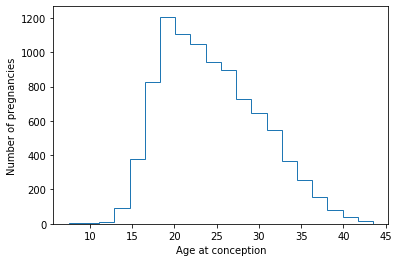

In [7]:
#distribution  of number of pregancies by age at conception
plt.hist(agecon, bins=20, histtype='step')

plt.xlabel('Age at conception')
plt.ylabel('Number of pregnancies')

plt.show()

#### Cleaning data

In [8]:
nsfg['nbrnaliv'].value_counts()

1.0    6379
2.0     100
3.0       5
8.0       1
Name: nbrnaliv, dtype: int64

In [9]:
nsfg['nbrnaliv'].replace(8, np.nan, inplace=True)

In [10]:
 nsfg['birthwgt_lb1'].value_counts().sort_index()

0.0        6
1.0       34
2.0       47
3.0       67
4.0      196
5.0      586
6.0     1666
7.0     2146
8.0     1168
9.0      363
10.0      82
11.0      17
12.0       7
13.0       2
14.0       2
17.0       1
98.0       1
99.0      94
Name: birthwgt_lb1, dtype: int64

In [11]:
#compute the average birth weight for full-term babies.

#resample data
def resample_rows_weighted(df, column='wgt2013_2015'):
    """Resamples a DataFrame using probabilities proportional to given column.
    df: DataFrame
    column: string column name to use as weights
    returns: DataFrame
    """
    weights = df[column].copy()
    weights /= sum(weights)
    indices = np.random.choice(df.index, len(df), replace=True, p=weights)
    sample = df.loc[indices]
    return sample
    


In [12]:
nsfg = resample_rows_weighted(nsfg, 'wgt2013_2015')
nsfg.head()

,caseid,outcome,birthwgt_lb1,birthwgt_oz1,prglngth,nbrnaliv,agecon,agepreg,hpagelb,wgt2013_2015
6414,67447,1,8.0,7.0,39,1.0,3175,3250.0,31.0,12251.547406
9075,70343,1,5.0,15.0,40,1.0,2700,2775.0,30.0,56848.676066
9333,70606,1,5.0,6.0,38,1.0,2108,2175.0,22.0,9470.209317
4693,65511,1,10.0,0.0,39,1.0,3483,3558.0,35.0,8059.756425
974,61520,4,NaN,NaN,9,NaN,3541,3558.0,NaN,18368.805712


In [13]:
# Clean the weight variables
nsfg['birthwgt_lb1'].replace([98,99], np.nan, inplace=True) 
nsfg['birthwgt_oz1'].replace([98,99], np.nan, inplace=True) 

birth_weight = nsfg['birthwgt_lb1'] + nsfg['birthwgt_oz1']/16

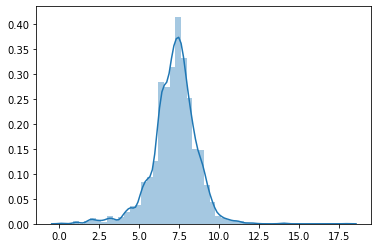

In [14]:
sns.distplot(birth_weight)

In [15]:
full_term =nsfg['prglngth']>= 37
full_term_weight = birth_weight[full_term]
print(full_term_weight.mean())

pre_term_weight = birth_weight[~full_term]
print(pre_term_weight.mean())

7.412735426008968
5.7395114942528735


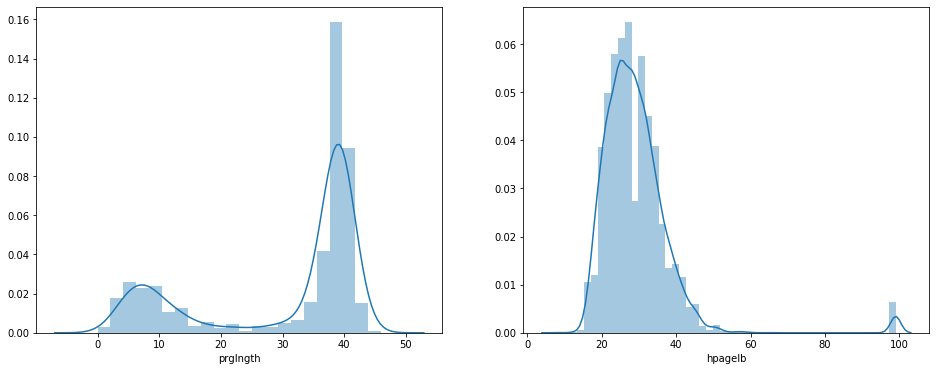

In [16]:
f, ax = plt.subplots(1, 2, figsize=(16,6), sharex=False)

sns.distplot(nsfg['prglngth'], ax=ax[0])
sns.distplot(nsfg['hpagelb'], ax=ax[1])

In [17]:
#compute full term weight for single vs multiple babies
single = nsfg['nbrnaliv'] == 1

single_ft_weight = birth_weight[full_term & single] 
print('mean single full term weight:' + str(single_ft_weight.mean()))

multi_ft_weight = birth_weight[full_term & ~single] 
print('mean multiple full term weight:' + str(multi_ft_weight.mean()))

mean single full term weight:7.423719049340321
mean multiple full term weight:5.965773809523809
